## Starter Notebook

- **Backbone**: EfficientNet-V2 Small (pretrained)  
- **Image size**: 224×224, no augmentations  
- **Training**: mixed precision (AMP), Adam (LR = 1e-3), batch size 32, 10 epochs  
- **Validation**: 3-fold KFold, early stopping (patience 3)  
- **Inference**: infer the test, saved to `submission.csv`  


In [1]:
# Cell 1: Imports & Config
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torchvision import transforms
from torchvision.models import efficientnet_v2_s
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Config
TRAIN_DIR   = '/kaggle/input/kaust-vs-kku-tornament-round-2'
TEST_DIR    = '/kaggle/input/kaust-vs-kku-tornament-round-2/test'
IMAGE_SIZE  = 224
BATCH_SIZE  = 32
LR          = 1e-3
EPOCHS      = 10
FOLDS       = 3
PATIENCE    = 3
DEVICE      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

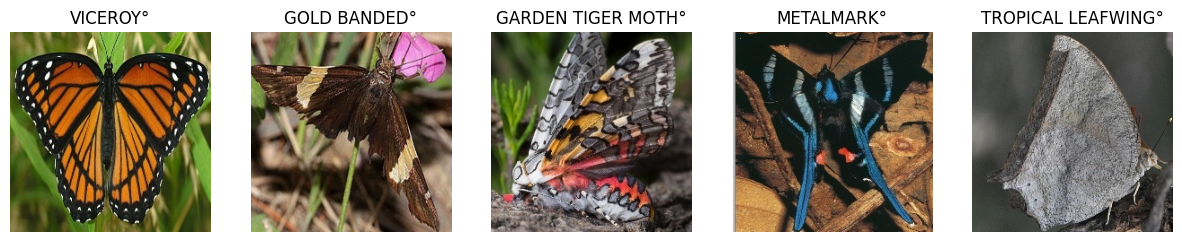

In [2]:
# Cell 2: Load & Visualize Data
train_df = pd.read_csv('/kaggle/input/kaust-vs-kku-tornament-round-2/train.csv')  
test_df  = pd.read_csv('/kaggle/input/kaust-vs-kku-tornament-round-2/test.csv')  

# Show a few samples
fig, axes = plt.subplots(1,5, figsize=(15,5))
for i, ax in enumerate(axes):
    row = train_df.sample(1, random_state=i+99699).iloc[0]
    img = Image.open(os.path.join(TRAIN_DIR, row['path'])).resize((IMAGE_SIZE,)*2)
    ax.imshow(img)
    ax.set_title(f"{row['label']}°")
    ax.axis('off')
plt.show()


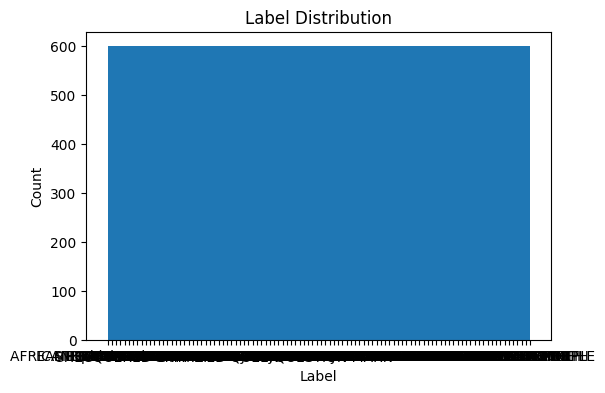

In [3]:
# label histogram
plt.figure(figsize=(6,4))
plt.hist(train_df['label'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

In [4]:
# Cell 3: Dataset + Transforms
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

class ButterflyDataset(Dataset):
    def __init__(self, csv_file, root_dir="/kaggle/input/kaust-vs-kku-tornament-round-2", transform=None, is_test=False, class_to_idx=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            is_test (bool): Whether this is test dataset (affects path handling)
            class_to_idx (dict): Pre-defined class to index mapping
        """
        if isinstance(csv_file, pd.DataFrame):
            self.data_frame = csv_file
        else:
            self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir if not is_test else root_dir + "/test"
        self.transform = transform
        self.is_test = is_test
        
        # Create label to index mapping
        if class_to_idx is None:
            self.classes = sorted(self.data_frame['label'].unique())
            self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        else:
            self.class_to_idx = class_to_idx
            self.classes = list(class_to_idx.keys())
        
        self.idx_to_class = {idx: cls for cls, idx in self.class_to_idx.items()}
    
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # get image path
        img_path = os.path.join(self.root_dir, self.data_frame.iloc[idx]['path'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # ---- ADD THIS BLOCK ----
        if self.is_test:
            # return dummy label (we ignore it during inference)
            return image, 0
        # -----------------------

        # training/validation: read real label
        label = self.data_frame.iloc[idx]['label']
        label_idx = self.class_to_idx[label]
        return image, label_idx



# Cell 5: Train & Validate Helpers
def train_one_epoch(loader):
    model.train(); total=0
    for x,y in tqdm(loader, desc='Train', leave=False):
        x,y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        with autocast():
            loss = criterion(model(x), y)
        scaler.scale(loss).backward()
        scaler.step(optimizer); scaler.update()
        total += loss.item()*x.size(0)
    return total/len(loader.dataset)

def validate(loader):
    model.eval(); total=0; all_preds=[]; all_labels=[]
    with torch.no_grad():
        for x,y in tqdm(loader, desc='Valid', leave=False):
            x,y = x.to(DEVICE), y.to(DEVICE)
            out = model(x); total += criterion(out,y).item()*x.size(0)
            all_preds.extend(out.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    return total/len(loader.dataset), f1_macro

In [5]:
# Cell 6: K-Fold Training + Early Stopping + OOF Collection
from sklearn.metrics import f1_score

# First, create consistent class mapping from full dataset
full_dataset = ButterflyDataset(train_df, transform=transform, is_test=False)
global_class_to_idx = full_dataset.class_to_idx
num_classes = len(global_class_to_idx)
print(f"Total classes in dataset: {num_classes}")

# Now create model with correct number of classes
model = efficientnet_v2_s(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scaler = GradScaler()   # used for mixed precision --> makes training faster and lighter

oof_preds = np.zeros(len(train_df), dtype=int)
oof_true = train_df['label'].map(global_class_to_idx).values
train_losses_folds = []
val_losses_folds = []
kf = KFold(FOLDS, shuffle=True, random_state=42)

for fold, (tr_idx, va_idx) in enumerate(kf.split(train_df, train_df['label'])):
    print(f"▶ Fold {fold+1}")
    df_tr, df_va = train_df.iloc[tr_idx], train_df.iloc[va_idx]
    tr_ld = DataLoader(ButterflyDataset(df_tr, transform=transform, is_test=False, class_to_idx=global_class_to_idx), 
                       batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    va_ld = DataLoader(ButterflyDataset(df_va, transform=transform, is_test=False, class_to_idx=global_class_to_idx), 
                       batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    
    best_loss, patience = float('inf'), 0
    tl_fold, vl_fold = [], []
    
    for ep in range(1, EPOCHS+1):
        tl = train_one_epoch(tr_ld)
        vl, vf1 = validate(va_ld)
        print(f" Epoch {ep} → train_loss={tl:.4f}, val_loss={vl:.4f}, val_f1={vf1:.4f}")
        tl_fold.append(tl)
        vl_fold.append(vl)
        
        if vl < best_loss:
            best_loss = vl
            torch.save(model.state_dict(), f'best_fold{fold}.pth')
            patience = 0
        else:
            patience += 1
            if patience >= PATIENCE:
                print(" ⏹ Early stopping")
                break
    
    train_losses_folds.append(tl_fold)
    val_losses_folds.append(vl_fold)
    
    # collect OOF predictions for this fold
    model.load_state_dict(torch.load(f'best_fold{fold}.pth'))
    model.eval()
    preds = []
    with torch.no_grad():
        for x, _ in DataLoader(ButterflyDataset(df_va, transform=transform, is_test=False, class_to_idx=global_class_to_idx),
                               batch_size=BATCH_SIZE, shuffle=False, num_workers=4):
            x = x.to(DEVICE)
            out = model(x).argmax(1).cpu().numpy()
            preds.extend(out)
    oof_preds[va_idx] = np.array(preds)

Total classes in dataset: 100


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 286MB/s]
/tmp/ipykernel_13/1770466827.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` in

▶ Fold 1


Train:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_13/446438711.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


 Epoch 1 → train_loss=1.7439, val_loss=0.9219, val_f1=0.7205


Train:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_13/446438711.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


 Epoch 2 → train_loss=0.5590, val_loss=0.7118, val_f1=0.8227


Train:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_13/446438711.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


 Epoch 3 → train_loss=0.3158, val_loss=0.5831, val_f1=0.8517


Train:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_13/446438711.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


 Epoch 4 → train_loss=0.2395, val_loss=2.1178, val_f1=0.8232


Train:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_13/446438711.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


 Epoch 5 → train_loss=0.1901, val_loss=0.4136, val_f1=0.8963


Train:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_13/446438711.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


 Epoch 6 → train_loss=0.1666, val_loss=0.5478, val_f1=0.8651


Train:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_13/446438711.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


 Epoch 7 → train_loss=0.1075, val_loss=0.5531, val_f1=0.8768


Train:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_13/446438711.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
                                                      

 Epoch 8 → train_loss=0.1008, val_loss=0.5515, val_f1=0.8710
 ⏹ Early stopping


▶ Fold 2


Train:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_13/446438711.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


 Epoch 1 → train_loss=0.4583, val_loss=0.4366, val_f1=0.8641


Train:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_13/446438711.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


 Epoch 2 → train_loss=0.2791, val_loss=0.3161, val_f1=0.8962


Train:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_13/446438711.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


 Epoch 3 → train_loss=0.1414, val_loss=0.2333, val_f1=0.9332


Train:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_13/446438711.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


 Epoch 4 → train_loss=0.0842, val_loss=0.2334, val_f1=0.9302


Train:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_13/446438711.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


 Epoch 5 → train_loss=0.0832, val_loss=0.2509, val_f1=0.9353


Train:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_13/446438711.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


 Epoch 6 → train_loss=0.0360, val_loss=0.2119, val_f1=0.9456


Train:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_13/446438711.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


 Epoch 7 → train_loss=0.0402, val_loss=0.1922, val_f1=0.9512


Train:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_13/446438711.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


 Epoch 8 → train_loss=0.0684, val_loss=0.4190, val_f1=0.9098


Train:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_13/446438711.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


 Epoch 9 → train_loss=0.0704, val_loss=0.2974, val_f1=0.9239


Train:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_13/446438711.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
                                                      

 Epoch 10 → train_loss=0.0655, val_loss=0.3322, val_f1=0.9186
 ⏹ Early stopping


▶ Fold 3


Train:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_13/446438711.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


 Epoch 1 → train_loss=0.2959, val_loss=0.3095, val_f1=0.8937


Train:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_13/446438711.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


 Epoch 2 → train_loss=0.2233, val_loss=0.3147, val_f1=0.9095


Train:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_13/446438711.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


 Epoch 3 → train_loss=0.1090, val_loss=0.1421, val_f1=0.9537


Train:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_13/446438711.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


 Epoch 4 → train_loss=0.0497, val_loss=0.1724, val_f1=0.9641


Train:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_13/446438711.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


 Epoch 5 → train_loss=0.0188, val_loss=0.0676, val_f1=0.9790


Train:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_13/446438711.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


 Epoch 6 → train_loss=0.0361, val_loss=0.0967, val_f1=0.9695


Train:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_13/446438711.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


 Epoch 7 → train_loss=0.0285, val_loss=0.0679, val_f1=0.9777


Train:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_13/446438711.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
                                                      

 Epoch 8 → train_loss=0.0297, val_loss=0.0776, val_f1=0.9722
 ⏹ Early stopping


In [6]:
# overall OOF F1 macro
oof_f1 = f1_score(oof_true, oof_preds, average="macro")
print(f"\nOverall OOF F1 Macro: {oof_f1:.4f}")


Overall OOF F1 Macro: 0.9434


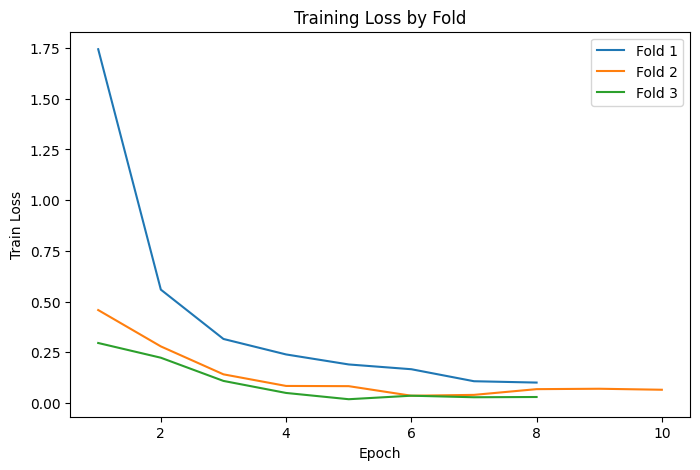

In [7]:
# Cell 7: Plot Training Loss per Fold
plt.figure(figsize=(8,5))
for i, tl in enumerate(train_losses_folds):
    plt.plot(range(1, len(tl)+1), tl, label=f'Fold {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Training Loss by Fold')
plt.legend()
plt.show()

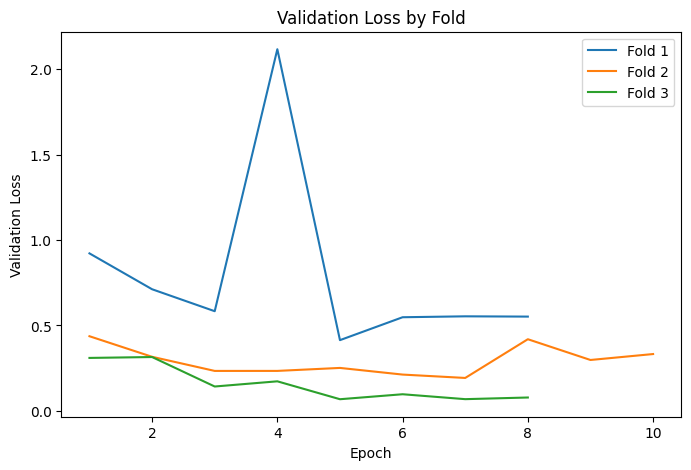

In [8]:
# Cell 8: Plot Validation Loss per Fold
plt.figure(figsize=(8,5))
for i, vl in enumerate(val_losses_folds):
    plt.plot(range(1, len(vl)+1), vl, label=f'Fold {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss by Fold')
plt.legend()
plt.show()

In [9]:
# Cell 8: Inference & Submission
test_ld = DataLoader(ButterflyDataset(test_df, transform=transform, is_test=True, class_to_idx=global_class_to_idx), 
                     batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Ensemble predictions from all folds
all_fold_preds = []
for fold in range(FOLDS):
    # Load the best model from this fold
    model.load_state_dict(torch.load(f'best_fold{fold}.pth'))
    model.eval()
    
    fold_preds = []
    with torch.no_grad():
        for x, _ in tqdm(test_ld, desc=f'Test Fold {fold+1}'):
            x = x.to(DEVICE)
            out = model(x).softmax(1).cpu().numpy()  # Use softmax for probabilities
            fold_preds.append(out)
    
    # Concatenate all batches for this fold
    fold_preds = np.concatenate(fold_preds, axis=0)
    all_fold_preds.append(fold_preds)

# Average predictions across all folds
ensemble_preds = np.mean(all_fold_preds, axis=0)
final_preds = ensemble_preds.argmax(1)

# Get filenames from test dataframe
fnames = test_df['path'].tolist() 

# Convert predictions back to original class labels
pred_labels = [full_dataset.idx_to_class[idx] for idx in final_preds]

sub = pd.DataFrame({'path': fnames, 'label': pred_labels})
sub.to_csv('submission.csv', index=False)
print(sub.head())

Test Fold 3: 100%|██████████| 47/47 [01:18<00:00,  1.66s/it]

                  path                label
0  test_img_000000.jpg      CHALK HILL BLUE
1  test_img_000001.jpg        CABBAGE WHITE
2  test_img_000002.jpg  YELLOW SWALLOW TAIL
3  test_img_000003.jpg           PAPER KITE
4  test_img_000004.jpg    BANDED TIGER MOTH
